In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

## Thrust Data

In [7]:
thrustFromFile = np.genfromtxt('./k1103x.csv',delimiter=',')

In [10]:
thrustFromFile[0,0] = 0.012

In [11]:
thrust = np.insert(thrustFromFile,0,[0,0],axis=0)

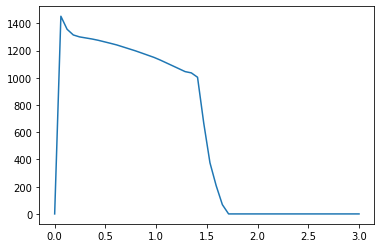

In [12]:
plt.plot(np.linspace(0,3),np.interp(np.linspace(0,3),thrust[:,0],thrust[:,1]));

In [83]:
#returns thrust force given a certain time in Newtons (N)
def thrustFunc(t):
    return 1.04*np.interp(t,thrust[:,0],thrust[:,1])

burnoutTime = 2.5
def massFunc(t):
    if(t<burnoutTime):
        return 6.44+1.46*(1-t/burnoutTime)
    else:
        return 6.44

#BAAAADDDD
#Please do better
def dragCoeffFunc(totalVel):
    return .541
#     if(totalVel<45):
#         return .435-(.435-.335)/45*totalVel
#     else:
#         return (.335*(210-totalVel)+.422*(totalVel-45))/(210-45)
    
    
#returns an approximation for the density of air at a given altitutde
def rho(altitude):
    rho0 = 1.225 #kg/m^3
    Hn = 10.4*10**3 #meters
    return rho0*np.exp(-altitude/Hn)

## Simulation settings

In [84]:
dt=0.001
tInitial = 0
tFinal = 100
time = np.arange(tInitial,tFinal,dt)

In [85]:
mass = 6.44 #kg
gravityForce = np.array([0,0,-9.81])*mass
Area = np.pi/4.0*(.102)**2
parachuteDragCoefficient = 10

In [86]:
#given the rockets position, velocity, drag Coefficient, and time, return how the velocity and position change
def derivative(position, velocity,dragCoefficient, t):
    #determine which way the rocket is pointing
    direction = velocity/(np.linalg.norm(velocity)+10**-9)
    
    #if on rail, launch angle is set
    if(position[2]<1):
        direction = np.array([0,np.sin(0.0873),np.cos(0.0873)])
    
    #wind force - random gusts of wind pushing the rocket on the way up
    #wind mostly blows side to side and not up and down (I think?)
    windforce = windFunc(t)*np.array([rand.normal(loc=1,scale=windxStdDev),rand.normal(loc=1,scale=windyStdDev),rand.normal(loc=windzRatio,scale=windzStdDev)])
    
    sumForces = gravityForce + (thrustFunc(t) - 1/2*Area*rho(position[2])*np.linalg.norm(velocity)**2*dragCoefficient)*direction+windforce
    
    return [sumForces/massFunc(t),velocity + sumForces/massFunc(t)*dt]
    
#function to perform integration step
#helpful to change out integration under the hood without needing to clutter main loop
def quadrature(position,velocity,dragCoefficient, t):
    
    #Heun's method
#     motion = derivative(position, velocity, dragCoefficient,t)
#     velocityGuess = velocity + motion[0]*dt
#     positionGuess = position + motion[1]*dt
    
#     motionUpdate = derivative(positionGuess,velocityGuess,dragCoefficient,t+dt)
    
#     velocityNext = velocity + dt/2*(motion[0]+motionUpdate[0])
#     positionNext = position + dt/2*(motion[1]+motionUpdate[1]) 
#     accelerationCurrent = 1/2*(motion[0]+motionUpdate[0])

    #Runge-Kutta method
    k1 = derivative(position, velocity, dragCoefficient,t)
    k2 = derivative(position + dt*k1[1]/2,velocity + dt*k1[0]/2,dragCoefficient,t+dt/2)
    k3 = derivative(position + dt*k2[1]/2,velocity + dt*k2[0]/2,dragCoefficient,t+dt/2)
    k4 = derivative(position + dt*k3[1],velocity + dt*k3[0],dragCoefficient,t+dt)
    
    velocityNext = velocity + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    positionNext = position + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])
    accelerationCurrent = 1/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    
    return positionNext, velocityNext, accelerationCurrent

## VLT

In [87]:
initialVel = 270
targetAlt = 1560.576
def velocityProfile(alt):
    return initialVel/np.sqrt(targetAlt)*np.sqrt(targetAlt-alt)

altitudes = np.linspace(0,targetAlt,100)

velocityLookupTableBase = np.array([altitudes,velocityProfile(altitudes)])
velocityLookupTable = np.transpose(np.genfromtxt('./DragVLT.csv',delimiter=','))
velocityLookupTable[1,-1] = 0
accelLookupTable = np.transpose(np.genfromtxt('./ALT.csv',delimiter=','))

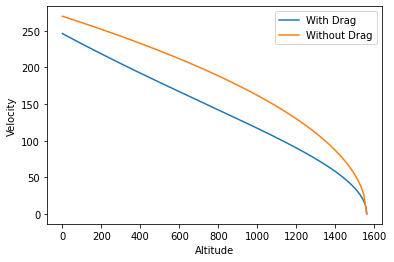

In [88]:
plt.plot(velocityLookupTable[0],velocityLookupTable[1]);
plt.plot(velocityLookupTableBase[0],velocityLookupTableBase[1]);
plt.legend(['With Drag','Without Drag']);
plt.xlabel('Altitude');
plt.ylabel('Velocity');

## Wind Settings

In [89]:
#function that kinda simulates random winds on the way up
def windFunc(time):
    return 3*(np.sin(time/2)+np.cos(time/20))

windxStdDev = .5
windyStdDev = .5
windzStdDev = .5
#ratio of z wind to xy wind
windzRatio = .5

## Controller Settings

In [109]:
controlFrequency= 20 #Hz
controldt = 1/controlFrequency
controlTicks = int(controldt//dt) #in number of ticks (if dt = 0.001, then this represents ms)
rocketDrag = 0.541
airbrakesMaxDrag = 0.25

def errorDecayFunc(alt):
    errorDecayTable = np.array([[targetAlt/4, targetAlt/2,7/8*targetAlt, 2*targetAlt],
                                [     40    ,   20      ,    10,           0]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((errorDecayTable[0]-alt)>0)
    return errorDecayTable[1,index]

def getMaxError(alt):
    maxErrorTable = np.array([[2/8*targetAlt,6/8*targetAlt, 2*targetAlt],
                                [    30      ,    10,           3]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((maxErrorTable[0]-alt)>0)
    return maxErrorTable[1,index]

def calculateError(position,velocity):
    altitude = position[2]
    velocityError = velocity[2] - float(np.interp(altitude, velocityLookupTable[0],velocityLookupTable[1]))
    return velocityError

def calculateAccelError(position,acceleration):
    altitude = position[2]
    accelerationError = acceleration[2] - np.interp(altitude, accelLookupTable[0],accelLookupTable[1])
    return accelerationError

## Airbrake Deployment

In [110]:
secondsPerDegree = 1/2*0.09/60 #number of seconds per degree 

def angleToDrag(profile):
    return profile/90*airbrakesMaxDrag

def deploymentProfile(currentDegrees, TargetDegrees):
    if currentDegrees < TargetDegrees:
        profile = np.linspace(currentDegrees,currentDegrees+controlTicks*dt/secondsPerDegree,num=controlTicks+1)
        profile[profile>TargetDegrees]=TargetDegrees
    else:
        profile = np.linspace(currentDegrees,currentDegrees-controlTicks*dt/secondsPerDegree,num=controlTicks+1)
        profile[profile<TargetDegrees]=TargetDegrees
    return profile

## Kalman Filter settings

In [128]:
#kalman step size
sampleFrequency = 100 #Hz
kdt = 1/sampleFrequency
#for loop
kalmanTicks = int(kdt//dt)

#state Vector
#X = [[x],[y],[z],[vx],[vy],[vz],[ax],[ay],[az]]

#state transition matrix
Fkalman = np.array([[1,0,0,kdt,  0,  0,1/2*kdt**2,         0,         0],
                    [0,1,0,  0,kdt,  0,         0,1/2*kdt**2,         0],
                    [0,0,1,  0,  0,kdt,         0,         0,1/2*kdt**2],
                    [0,0,0,  1,  0,  0,       kdt,         0,         0],
                    [0,0,0,  0,  1,  0,         0,       kdt,         0],
                    [0,0,0,  0,  0,  1,         0,         0,       kdt],
                    [0,0,0,  0,  0,  0,         1,         0,         0],
                    [0,0,0,  0,  0,  0,         0,         1,         0],
                    [0,0,0,  0,  0,  0,         0,         0,         1]])

#Input translation matrix
#take input accelerations from rocket thrust and turn that into state matrix adjustment
Gkalman = np.array([[1/2*kdt**2,0,0],
                    [0,1/2*kdt**2,0],
                    [0,0,1/2*kdt**2],
                    [kdt,0,0],
                    [0,kdt,0],
                    [0,0,kdt],
                    [1,0,0],
                    [0,1,0],
                    [0,0,1]])

#observation model
#converts state vector to equivalent oberservations 
#we get the altitude from the altimeter and the acceleration data from IMU
Hkalman = np.array([[0,0,1,0,0,0,0,0,0],
                    [0,0,0,0,0,0,1,0,0],
                    [0,0,0,0,0,0,0,1,0],
                    [0,0,0,0,0,0,0,0,1]])

#estimate covariance
#should be zero to start because we know exactly where the rocket starts
#however, setting it to this makes the kalman algorithm slow to adjust to the rapid start in motion
Pkalman = np.zeros((9,9))

#process noise
processVar=(.5)**2
Qkalman = np.matmul(Gkalman,np.transpose(Gkalman))*processVar

#measurement covariance
altimeterVar = 0.00841
accelXVar = 0.00032
accelYVar = 0.00032
accelZVar = 0.00032

#measurement covariance matrix
Rkalman = np.array([[altimeterVar,0,0,0],
                    [0,           accelXVar,0,0],
                    [0,           0,accelYVar,0],
                    [0,           0,0,accelZVar]])

#measurement drift settings
accelXdrift = 1*kdt #m/s
accelYdrift = 1*kdt #m/s
accelZdrift = 1*kdt #m/s

## Integration Loop

In [257]:
time = np.arange(tInitial,tFinal,dt)
positions = np.zeros((len(time),3)); # x,y,z
velocities = np.zeros((len(time),3)); # vx,vy,vz
accelerations = np.zeros((len(time),3)); #ax,ay,az
dragCoefficient  = np.full((len(time)),rocketDrag);
airbrakeDeploymentAngle  = np.full((len(time)),0);
errorArray = np.full((len(time)),0.0);
stateVectors = np.zeros((len(time),9));
measurements = np.zeros((len(time),4))
Pkalman = np.eye(9)*10
innovation = 0
innovationCov = 0

integralError = 0;
#used to turn off controller after apogee
runControl = False;
parachuteDeployed = False;

#used to truncate data
finalTick = 0

for i in range(len(time)-1):
    
    #see quadrature equation for how integration occurs
    positions[i+1], velocities[i+1], accelerations[i]  = quadrature(positions[i],velocities[i],dragCoefficient[i],time[i]) 
    
    #ends simulation when rocket hits ground
    if (positions[i,2]<=0) and (time[i]>1):
        finalTick = i
        break
    
    #Kalman filter attempt
    if((i%kalmanTicks==0) and (i>0)):
        #takes the current altitude and x,y,z accelerations and adds defined noise to those values
        #these values become the measurement that is fed into the kalman filter
        #the first step of the kalman filter is to predict what the next state should be based on the previous
        #step and the state transition matrix (essentially just forward integration)
        #it then converts this into the measurement space with Hkalman and comapres this with actual measured values
        #this difference is called the innovation
        #the kalman filter then corrects its guess at the next state by calculating the optimal gain Kkalman
        #Kkalman is determined by comparing the estimate covariance (how confident it is in the current estimate) and 
        #the innovation covariance (how confident it is in the measurement)
        
        #take measurement


        measurements[i:i+kalmanTicks] = [positions[i,2]+rand.normal(0,np.sqrt(altimeterVar)),
                                         accelerations[i,0]+rand.normal(accelXdrift,np.sqrt(accelXVar)),
                                         accelerations[i,1]+rand.normal(accelYdrift,np.sqrt(accelYVar)),
                                         accelerations[i,2]+rand.normal(accelZdrift,np.sqrt(accelZVar))]
        
        saturation = measurements[i:i+kalmanTicks,1:4] > 8*9.81
        
        measurements[i:i+kalmanTicks,1:4][saturation] = 8*9.81
        
        ###Predict Step        
        stateVectors[i:i+kalmanTicks] = np.matmul(Fkalman, stateVectors[i-kalmanTicks])
        #Potentially add step that increases Qkalman during motor burn, then decreases it
        Pkalman = np.matmul(Fkalman,np.matmul(Pkalman,np.transpose(Fkalman))) + Qkalman
        
        ###Update Step
        innovation = measurements[i] - np.matmul(Hkalman,stateVectors[i])
        
        innovationCov = np.matmul(Hkalman,np.matmul(Pkalman,np.transpose(Hkalman)))+Rkalman
        
        #optimal Kalman Gain
        Kkalman = np.matmul(Pkalman,np.matmul(np.transpose(Hkalman),np.linalg.inv(innovationCov)))
        #print(np.linalg.norm(Kkalman))
        
        #update state estimate
        stateVectors[i:i+kalmanTicks] = stateVectors[i] + np.matmul(Kkalman,innovation)
        #update estimate covariance
        Pkalman = np.matmul((np.eye(9)-np.matmul(Kkalman,Hkalman)),Pkalman)
    
    #turn on controller when motor burns out
    if((((stateVectors[i,8]<= -15) and (runControl==False)) and parachuteDeployed==False) and time[i]>1):
        print("Controller turned on at "+ str(time[i]))
        #stateVectors[i:i+kalmanTicks,2] = measurements[i:i+kalmanTicks,0]
        #stateVectors[i:i+kalmanTicks,5] = -(measurements[i,3] - measurements[i-2*kalmanTicks,3])/(2*kdt)
        #stateVectors[i:i+kalmanTicks,8] = measurements[i:i+kalmanTicks,3]
        runControl = True
        
    #deploy parachute when rocket hits apogee
    if ((stateVectors[i,5]<=0) and (time[i]>1)) and runControl == True:
        runControl = False
        parachuteDeployed = True
        print("Controller turned off at "+ str(time[i]))
        dragCoefficient[i:] = parachuteDragCoefficient
        
    #control algorithim, evaluate periodically (250 ticks or 250 m/s)
    if(i%controlTicks==0) and runControl:
        #control algorithm outline
        # - determine how off the rocket velocity is from VLT given altitude
        #     - clip this value so that it less than the max allowable
        # - add the current error to the integral error term
        #     - subtract error decay given altitude
        #     - integral error penalizes being wrong for long period of time
        #     - have decay so that it doesn't always blow up to inf + allows me to make controller more strict over time
        # - control parameter is determined by summing current error and integral error and dividing by max error
        #     - airbrakes are then deployed such that that percentage of the drag coefficient is deployed
        #     - TODO: create transfer function from control parameter to deployment percentage
        #         - assume to be linear initially
        
        maxError = getMaxError(stateVectors[i,2])
        #calculate how off the velocity is from desired
        errorArray[i+controlTicks] = calculateError(stateVectors[i,0:3],stateVectors[i,3:6])
        
        #add this error to integralError
        #This will take account of continually wrong velocities and give it a boost
        #errorDecay helps this term not just grow over time
        #effectively means it will help velocity get within errorDecay of desiredVelocity
        
        integralError += 1/controlFrequency*(errorArray[i] - errorDecayFunc(positions[i,2]))
        #integralError = 1/controlFrequency*np.sum(errorArray[i-64*controlTicks:i+controlTicks])/65
        #integralError = stateVectors[i,2]-np.interp(stateVectors[i,5], np.flip(velocityLookupTable[1]),np.flip(velocityLookupTable[0]))
        
        #if within a close value of the target vel, set the integral error to zero so that we don't overshoot
        if errorArray[i]<.1:
            integralError = 0
        
        if integralError < 0:
            integralError = 0
        
        errorDerivative = errorArray[i]-errorArray[i-controlTicks]
        #errorDerivative = controldt * calculateAccelError(stateVectors[i,0:3],stateVectors[i,6:9])
        
        print("Alt: "+str(stateVectors[i,2]/targetAlt), end='   ')
        print("Error: "+ str(errorArray[i]),end = '   ')
        print("INT Error: "+str(integralError),end='   ')
        print("DER Error "+ str(errorDerivative))
        
        #calculate how much control we want to exert as a function of the maximum
        control = (1*errorArray[i]+.2*integralError+.2*errorDerivative)/maxError
        
        #if hit target, stop controlling
        if errorArray[i]<=.01:
            control = 0
        
        #if control is greater than 1, bring it down
        if control >1:
            control = 1
        if control <0:
            control = 0
        
        targetAngle = 90*control
        
        airbrakeDeploymentAngle[i:i+controlTicks+1] = deploymentProfile(airbrakeDeploymentAngle[i-1],targetAngle)
        
        #adjust the drag coefficient for the next section of the simulation
        #MOVE OUT OF CONTROL LOOP
        totalVelocity = np.linalg.norm(velocities[i])
        dragCoefficient[i:i+controlTicks+1] = dragCoeffFunc(totalVelocity)+angleToDrag(airbrakeDeploymentAngle[i:i+controlTicks+1])
    
        
time = time[:finalTick]
measurements = measurements[:finalTick]
positions = positions[:finalTick]
velocities = velocities[:finalTick]
accelerations = accelerations[:finalTick]
stateVectors = stateVectors[:finalTick]
dragCoefficient = dragCoefficient[:finalTick]
airbrakeDeploymentAngle = airbrakeDeploymentAngle[:finalTick]

Controller turned on at 1.6500000000000001
Alt: 0.12771605310095113   Error: 0.0   INT Error: 0   DER Error 0.0
Alt: 0.1346969392395584   Error: -33.39717285741628   INT Error: 0   DER Error -33.39717285741628
Alt: 0.14166598982352097   Error: -31.712794568094438   INT Error: 0   DER Error 1.6843782893218417
Alt: 0.14862033985569298   Error: -30.23946874164463   INT Error: 0   DER Error 1.473325826449809
Alt: 0.1555535066125397   Error: -28.826067071680512   INT Error: 0   DER Error 1.4134016699641165
Alt: 0.16246746193852588   Error: -27.47394856640588   INT Error: 0   DER Error 1.3521185052746318
Alt: 0.16935457299614   Error: -26.175970372621435   INT Error: 0   DER Error 1.297978193784445
Alt: 0.17620973789659586   Error: -24.942444594235212   INT Error: 0   DER Error 1.2335257783862232
Alt: 0.18303595883629845   Error: -23.765257761226508   INT Error: 0   DER Error 1.1771868330087045
Alt: 0.18983429213863887   Error: -22.638744400287948   INT Error: 0   DER Error 1.12651336093856


Alt: 0.6606920143567996   Error: 3.9491930023980046   INT Error: 0   DER Error 0.045413829267531014
Alt: 0.6645602208083979   Error: 3.9933355791877716   INT Error: 0   DER Error 0.04414257678976696
Alt: 0.6683997710252496   Error: 4.043784496147268   INT Error: 0   DER Error 0.05044891695949616
Alt: 0.6722138252756261   Error: 4.085982402986744   INT Error: 0   DER Error 0.04219790683947622
Alt: 0.6760027697841836   Error: 4.126867431063431   INT Error: 0   DER Error 0.040885028076687036
Alt: 0.6797645722683188   Error: 4.169224713464658   INT Error: 0   DER Error 0.042357282401226826
Alt: 0.6835010270777598   Error: 4.211208610457774   INT Error: 0   DER Error 0.04198389699311633
Alt: 0.6872145124872624   Error: 4.247979712983124   INT Error: 0   DER Error 0.036771102525349875
Alt: 0.6908997390232962   Error: 4.286903662083148   INT Error: 0   DER Error 0.03892394910002395
Alt: 0.6945612013479657   Error: 4.320293797340298   INT Error: 0   DER Error 0.03339013525715018
Alt: 0.6981980

Alt: 0.9231014096414308   Error: 4.968194299486434   INT Error: 5.929749583973653   DER Error 0.027006715972376583
Alt: 0.9248537943476329   Error: 4.9950526483788735   INT Error: 6.179502216392597   DER Error 0.02685834889243921
Alt: 0.9265865970686952   Error: 5.025918888754944   INT Error: 6.430798160830344   DER Error 0.030866240376070664
Alt: 0.9283019454879922   Error: 5.055561808276032   INT Error: 6.683576251244146   DER Error 0.029642919521087663
Alt: 0.9299982980924709   Error: 5.087323236232336   INT Error: 6.9379424130557625   DER Error 0.031761427956304544
Alt: 0.9316756819361995   Error: 5.120151351961745   INT Error: 7.19394998065385   DER Error 0.03282811572940858
Alt: 0.9333341731521689   Error: 5.154670627139481   INT Error: 7.451683512010824   DER Error 0.03451927517773612
Alt: 0.9349743300928537   Error: 5.193490175709506   INT Error: 7.7113580207962995   DER Error 0.03881954857002512
Alt: 0.9365977317872276   Error: 5.230741443534818   INT Error: 7.97289509297304  

Alt: 1.0131169392538837   Error: 7.138254130480416   INT Error: 52.28400144586595   DER Error -0.4826521401034656
Alt: 1.013317344561552   Error: 6.662577431312539   INT Error: 52.617130317431574   DER Error -0.47567669916787647
Alt: 1.0135028022091317   Error: 6.194449241157153   INT Error: 52.92685277948943   DER Error -0.46812819015538665
Alt: 1.0136716197015436   Error: 5.717038188255674   INT Error: 53.212704688902214   DER Error -0.4774110529014788
Alt: 1.01382788257356   Error: 5.232787614622543   INT Error: 53.47434406963334   DER Error -0.4842505736331306
Alt: 1.0139658700067395   Error: 4.757340488899   INT Error: 53.71221109407829   DER Error -0.47544712572354353
Alt: 1.0140895952035605   Error: 4.278290243045897   INT Error: 53.926125606230585   DER Error -0.4790502458531023
Alt: 1.0141984613911343   Error: 3.804872272974704   INT Error: 54.11636921987932   DER Error -0.47341797007119313
Alt: 1.0142914087476849   Error: 3.3272355196655843   INT Error: 54.28273099586259   DE

## Plots

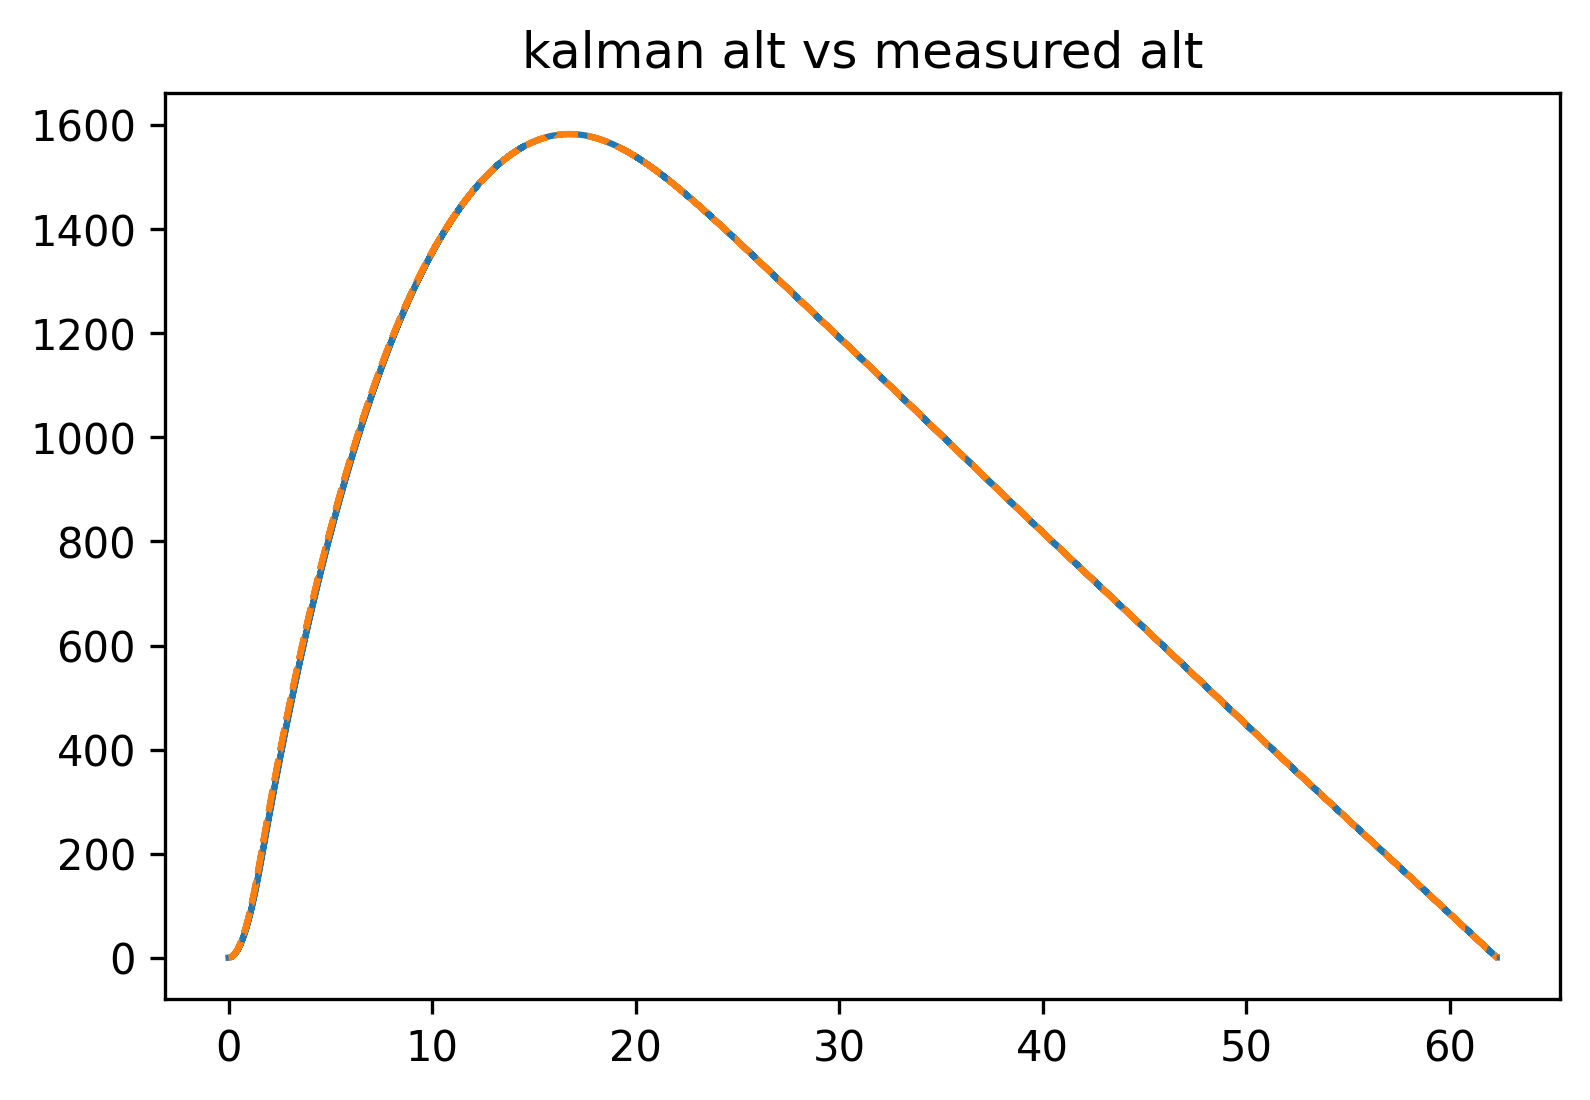

In [258]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,2])
plt.plot(time,measurements[:,0],'--');
plt.title('kalman alt vs measured alt');
plt.gcf().set_facecolor('white')

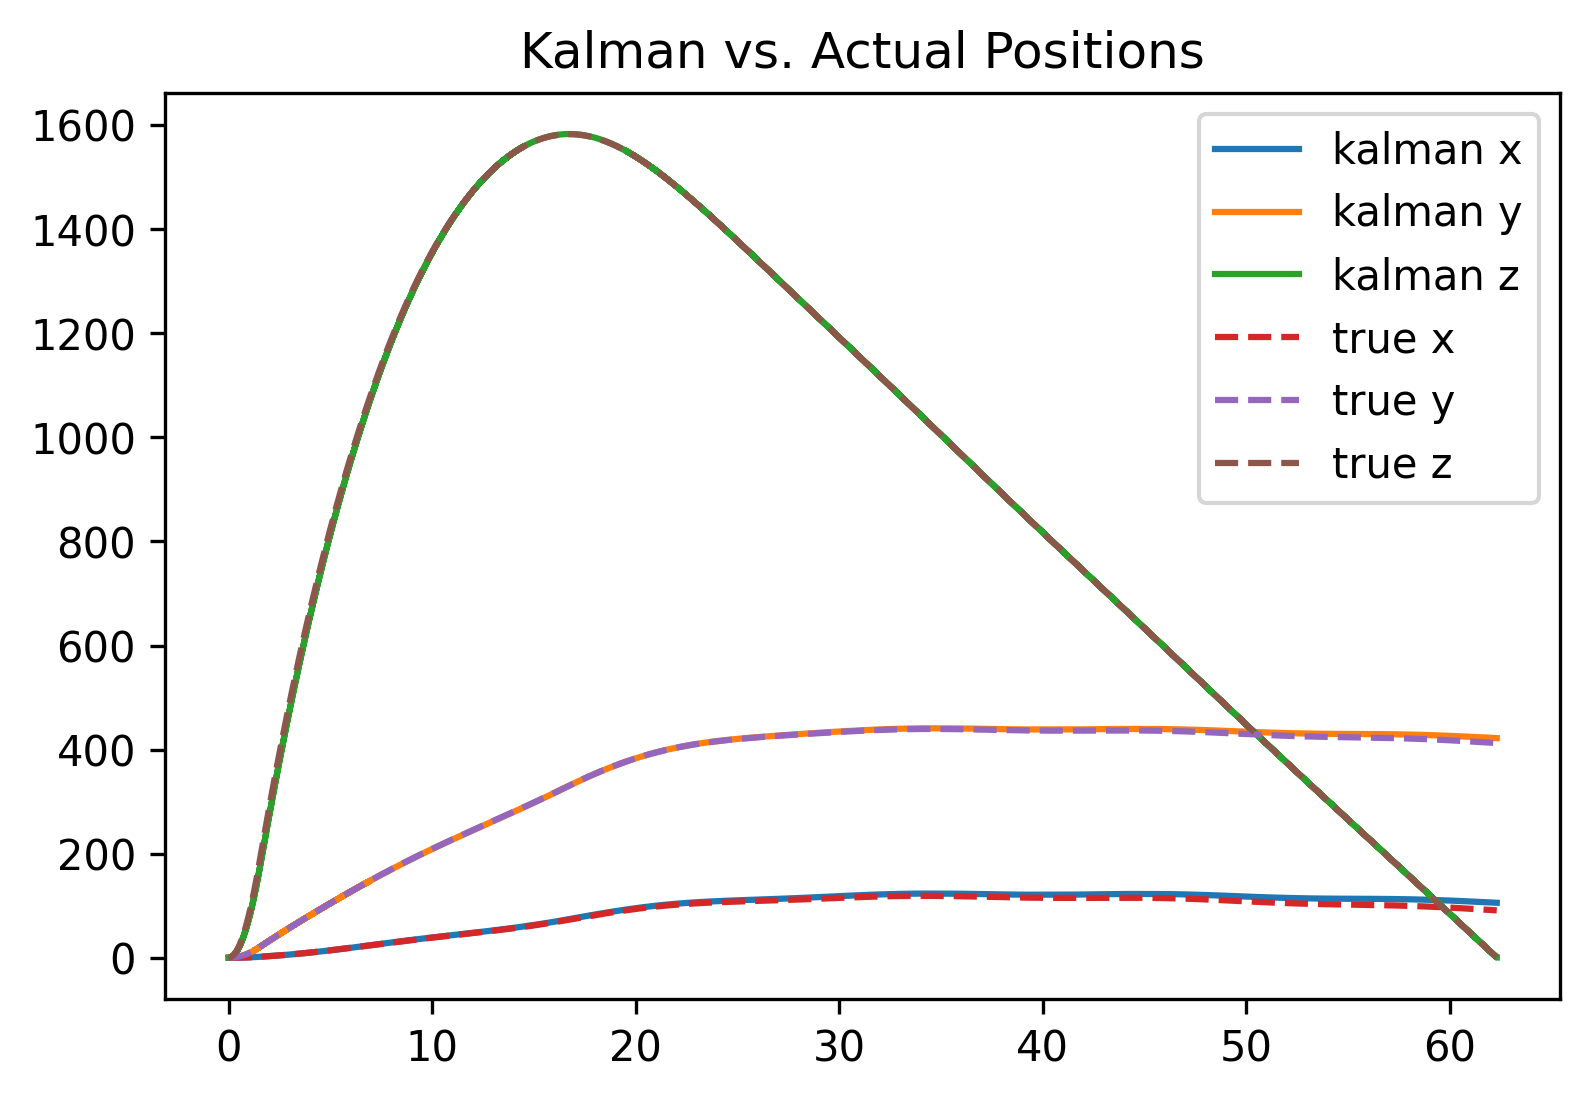

In [259]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,0:3]);
plt.plot(time,positions,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. Actual Positions');
plt.gcf().set_facecolor('white')

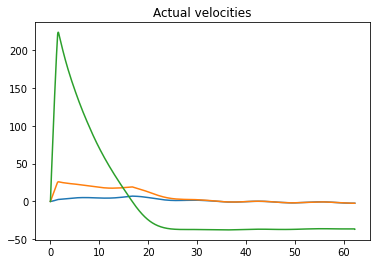

In [260]:
plt.plot(time,velocities);
plt.title('Actual velocities');
plt.gcf().set_facecolor('white')

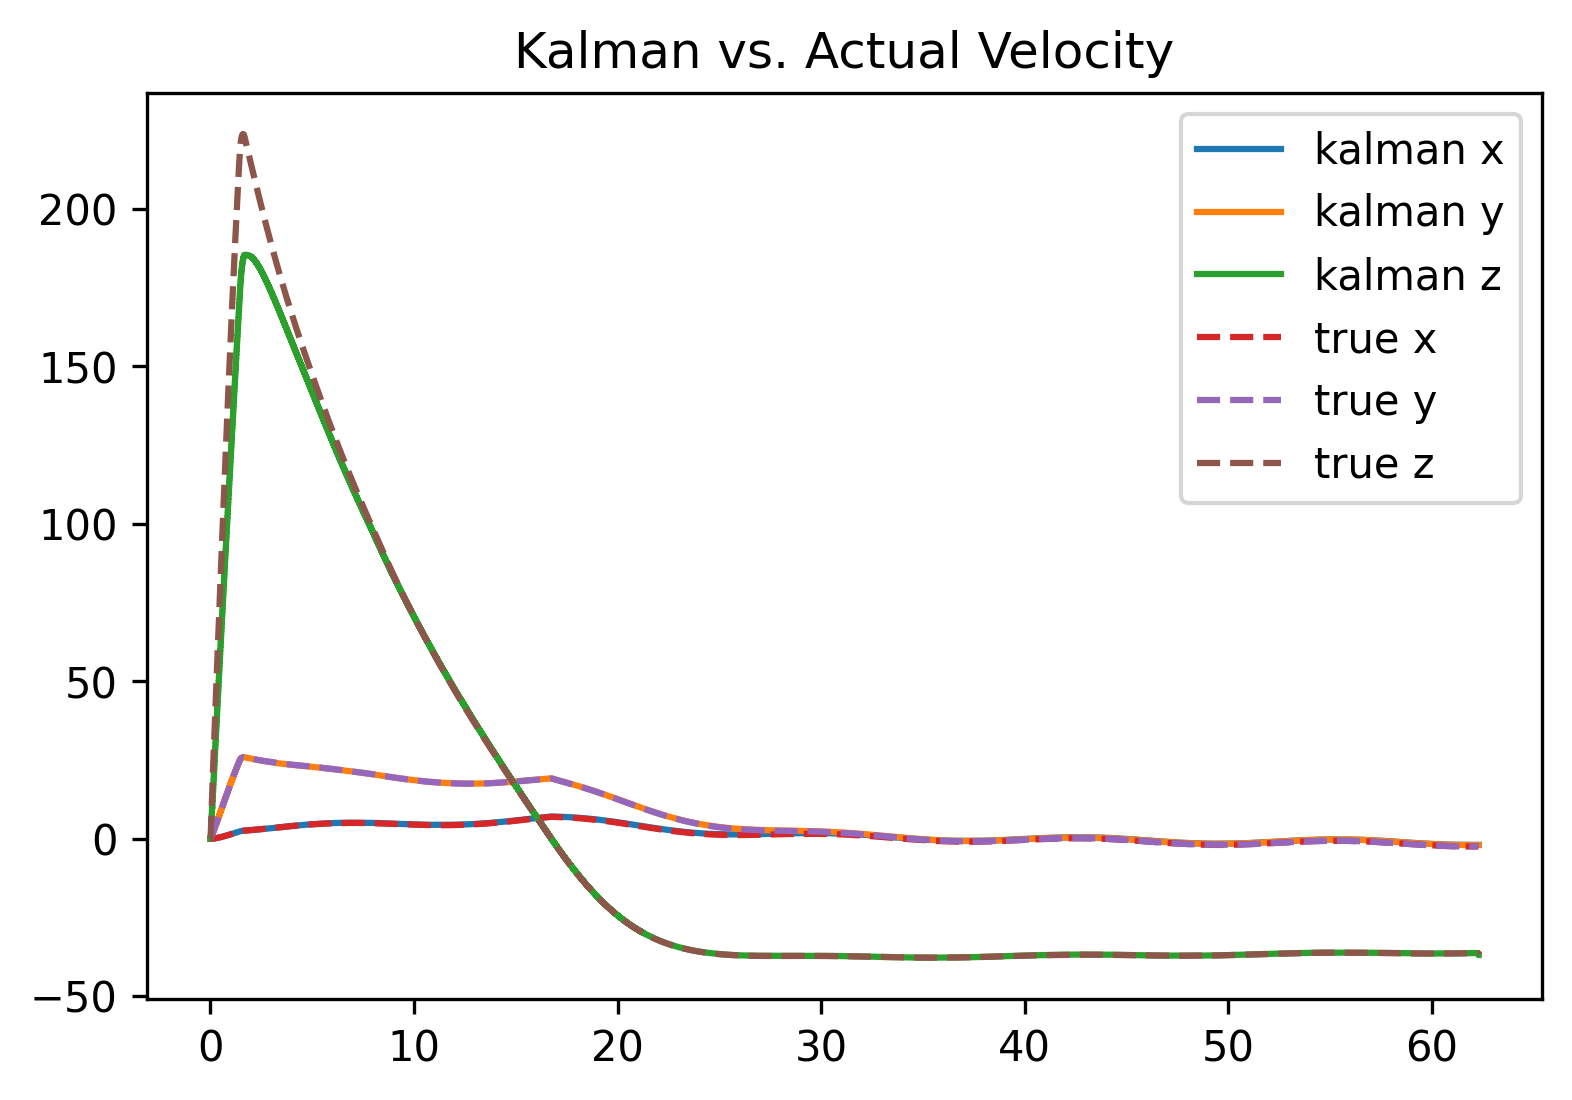

In [261]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,3:6]);
plt.plot(time,velocities,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. Actual Velocity');
plt.gcf().set_facecolor('white')

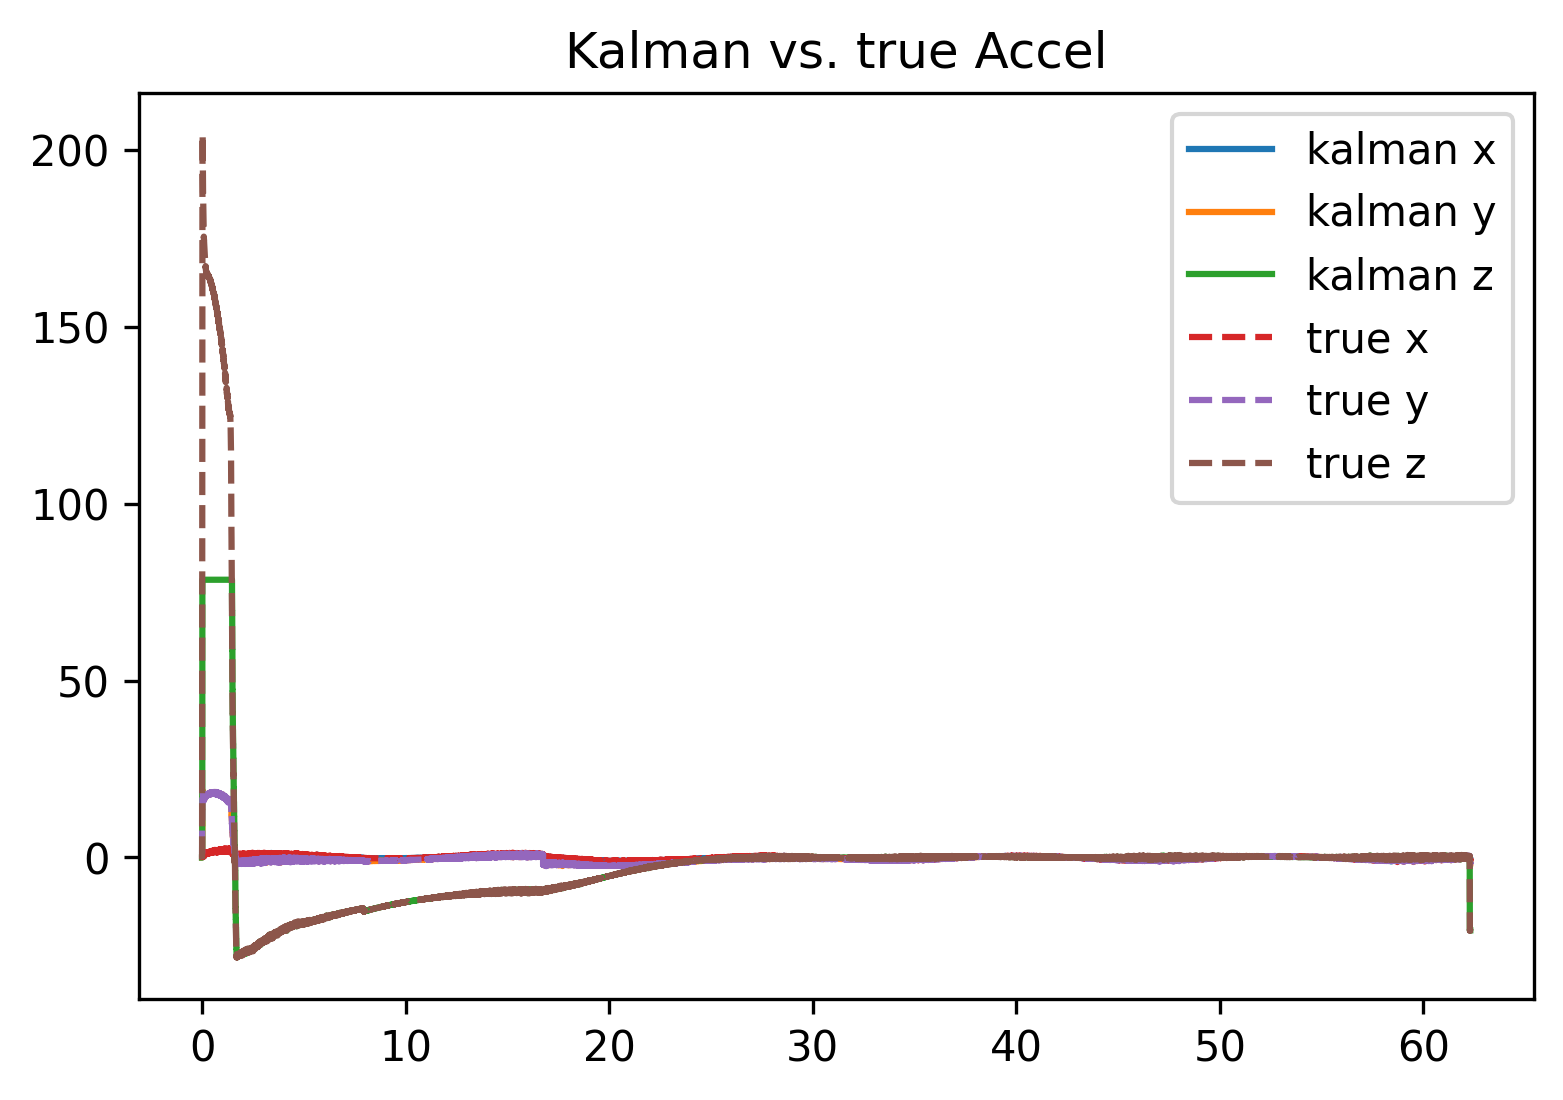

In [262]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, accelerations,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. true Accel');
#plt.xlim([0,10]);
plt.gcf().set_facecolor('white')

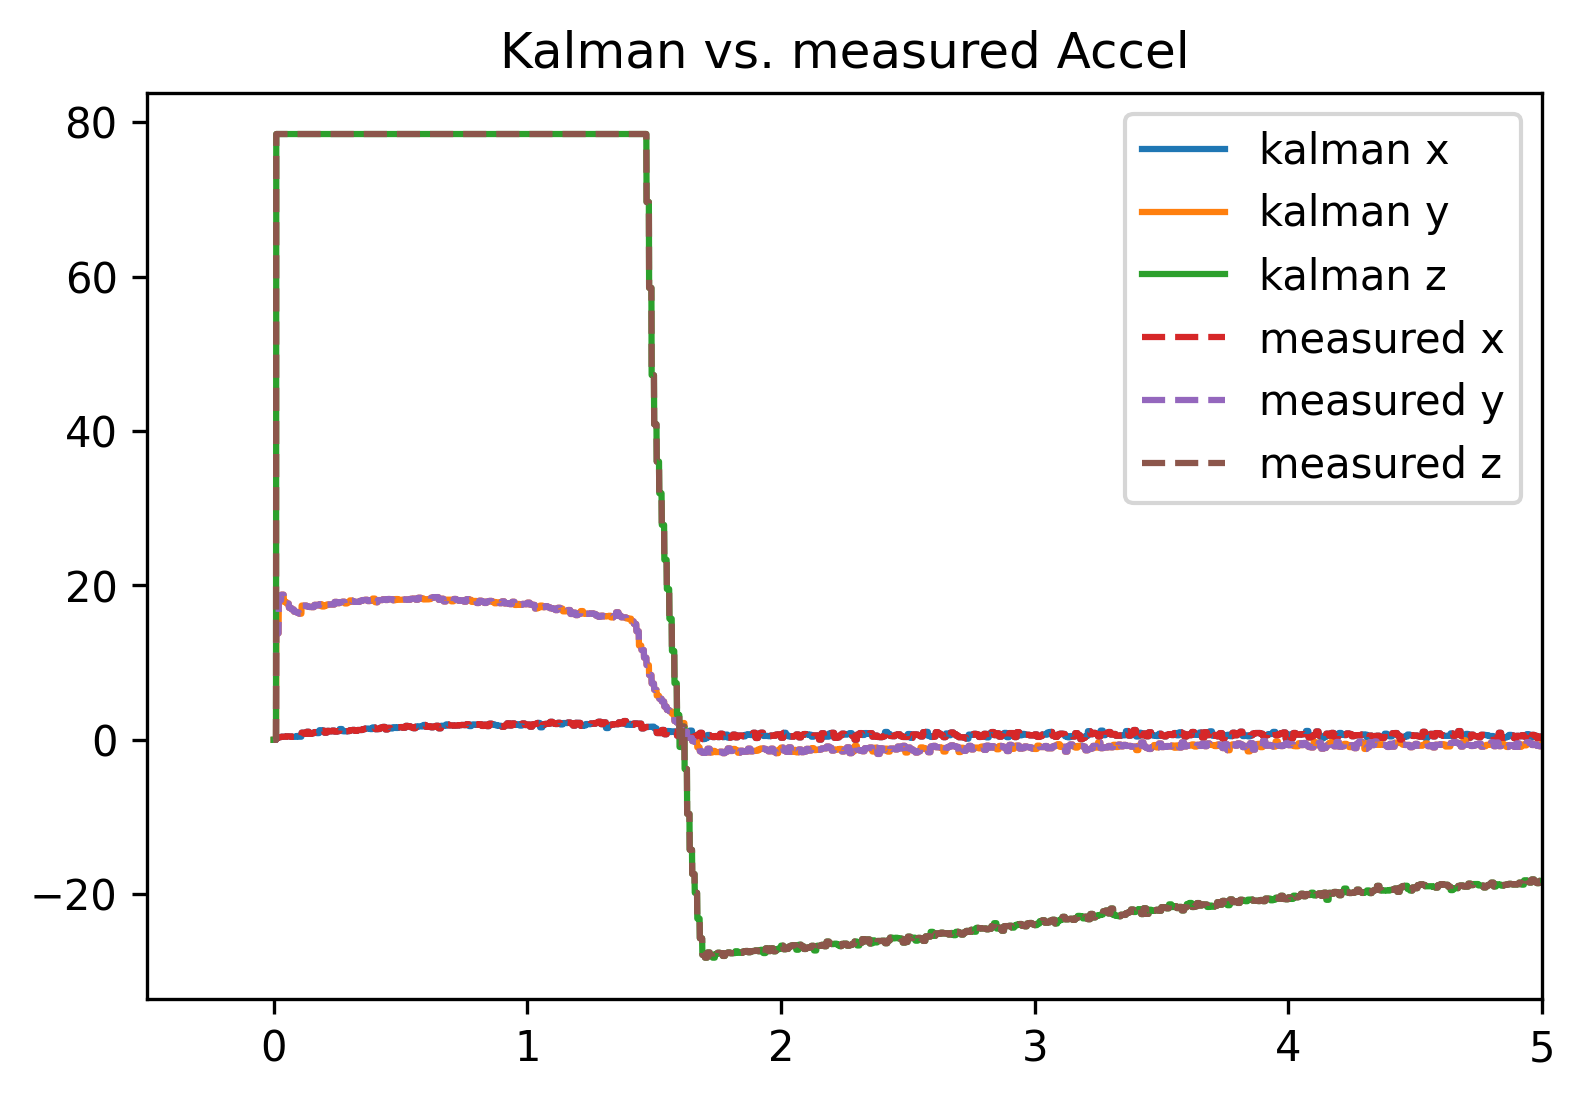

In [263]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, measurements[:,1:4],'--');
plt.legend(['kalman x','kalman y','kalman z','measured x','measured y','measured z'],loc='upper right');
plt.title('Kalman vs. measured Accel');
plt.xlim([-.5,5]);
plt.gcf().set_facecolor('white')

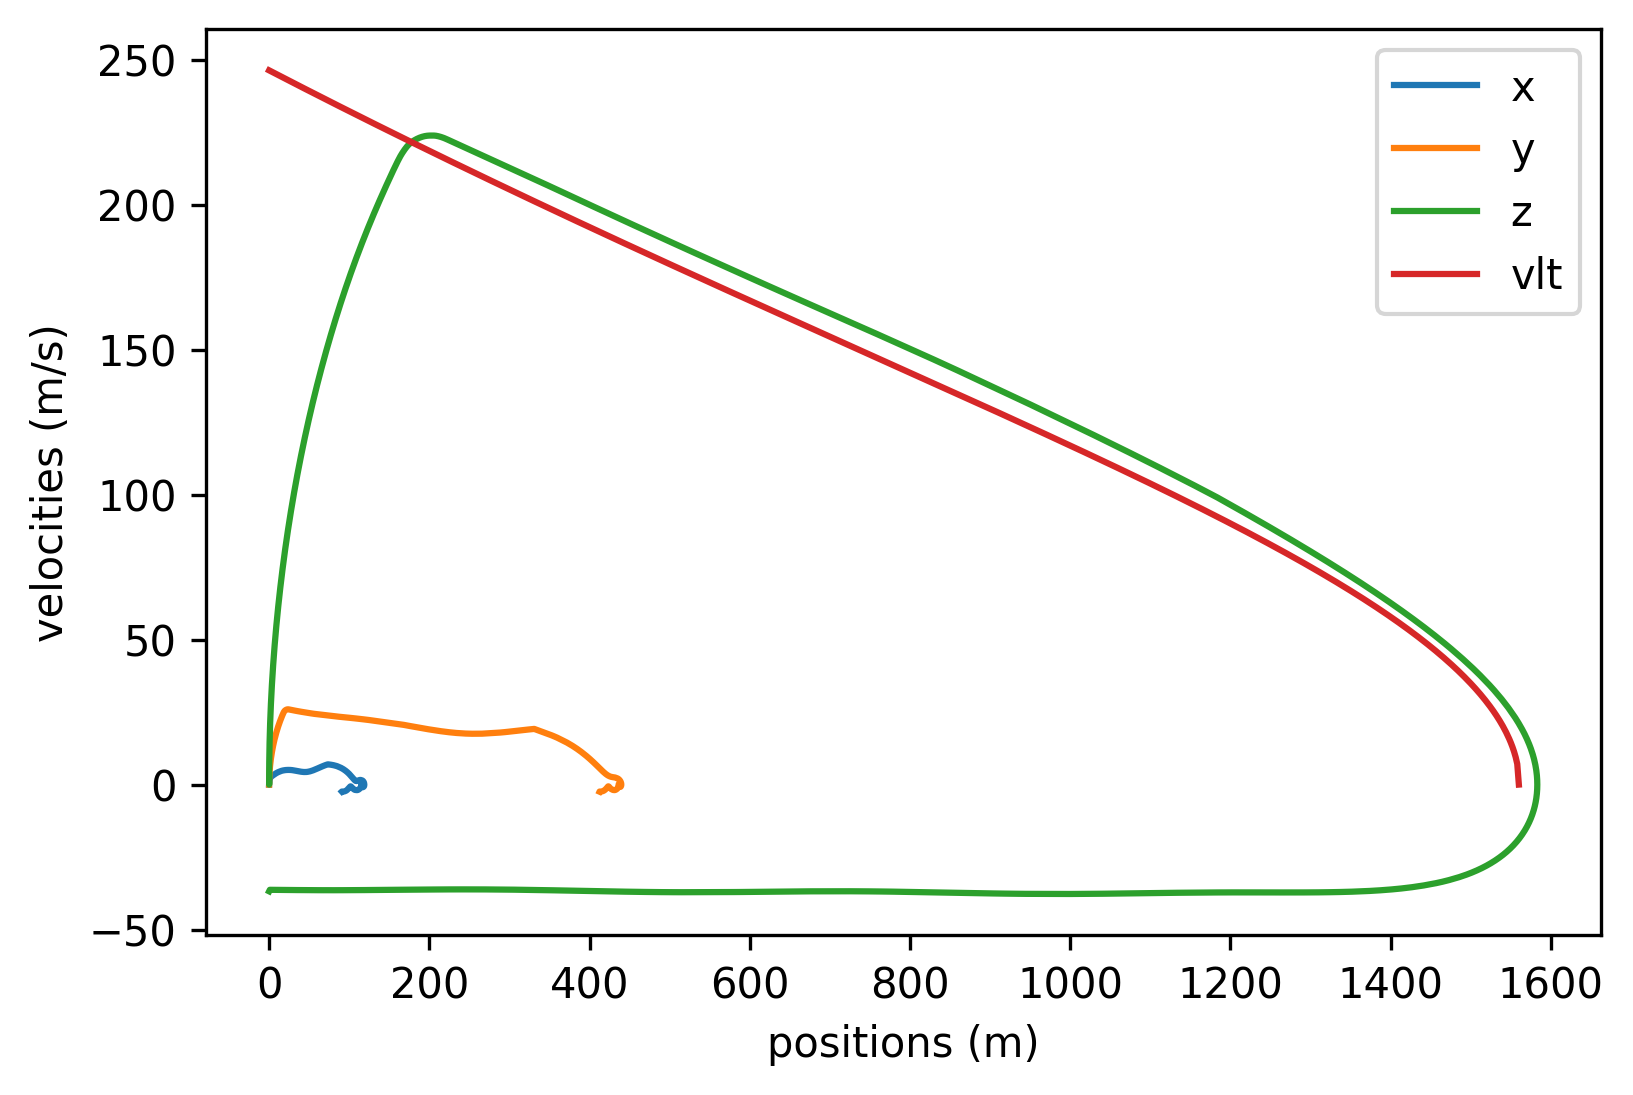

In [264]:
plt.figure(dpi=300)
plt.plot(positions,velocities);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('positions (m)')
plt.ylabel('velocities (m/s)')
plt.legend(['x','y','z','vlt'],loc='upper right');
plt.gcf().set_facecolor('white')

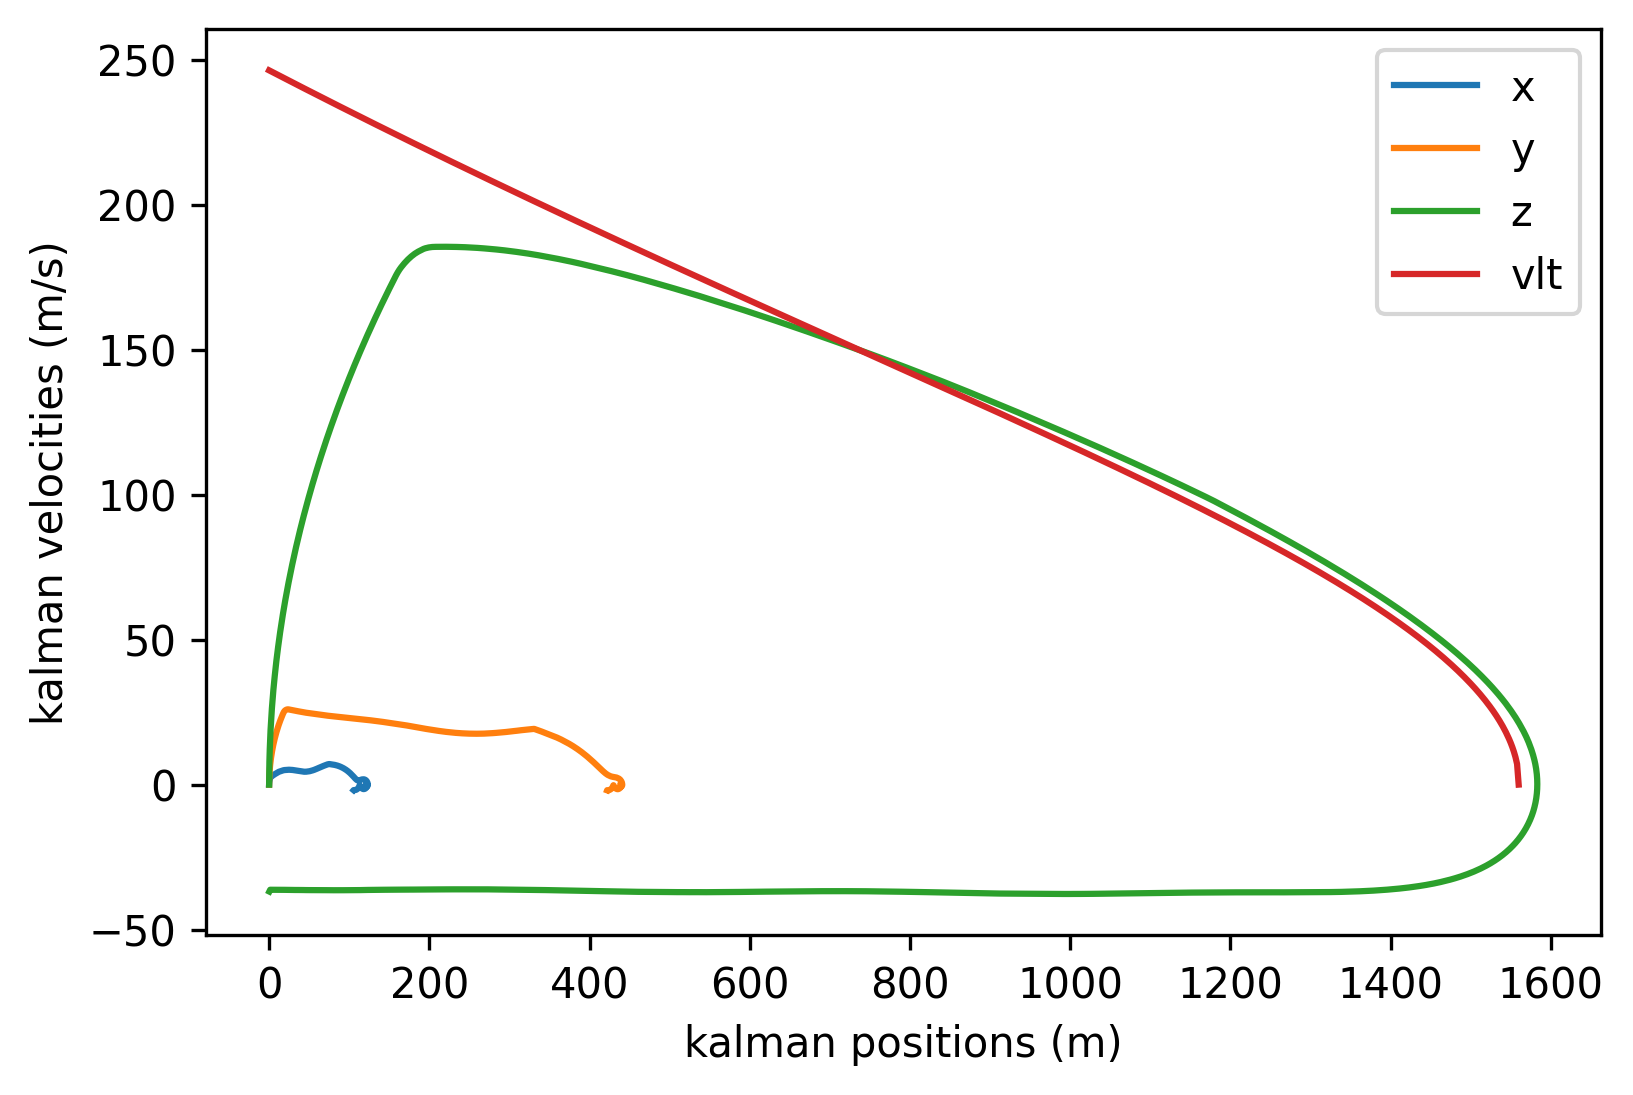

In [265]:
plt.figure(dpi=300)
plt.plot(stateVectors[:,0:3],stateVectors[:,3:6]);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('kalman positions (m)')
plt.ylabel('kalman velocities (m/s)')
plt.legend(['x','y','z','vlt'],loc='upper right');
plt.gcf().set_facecolor('white')

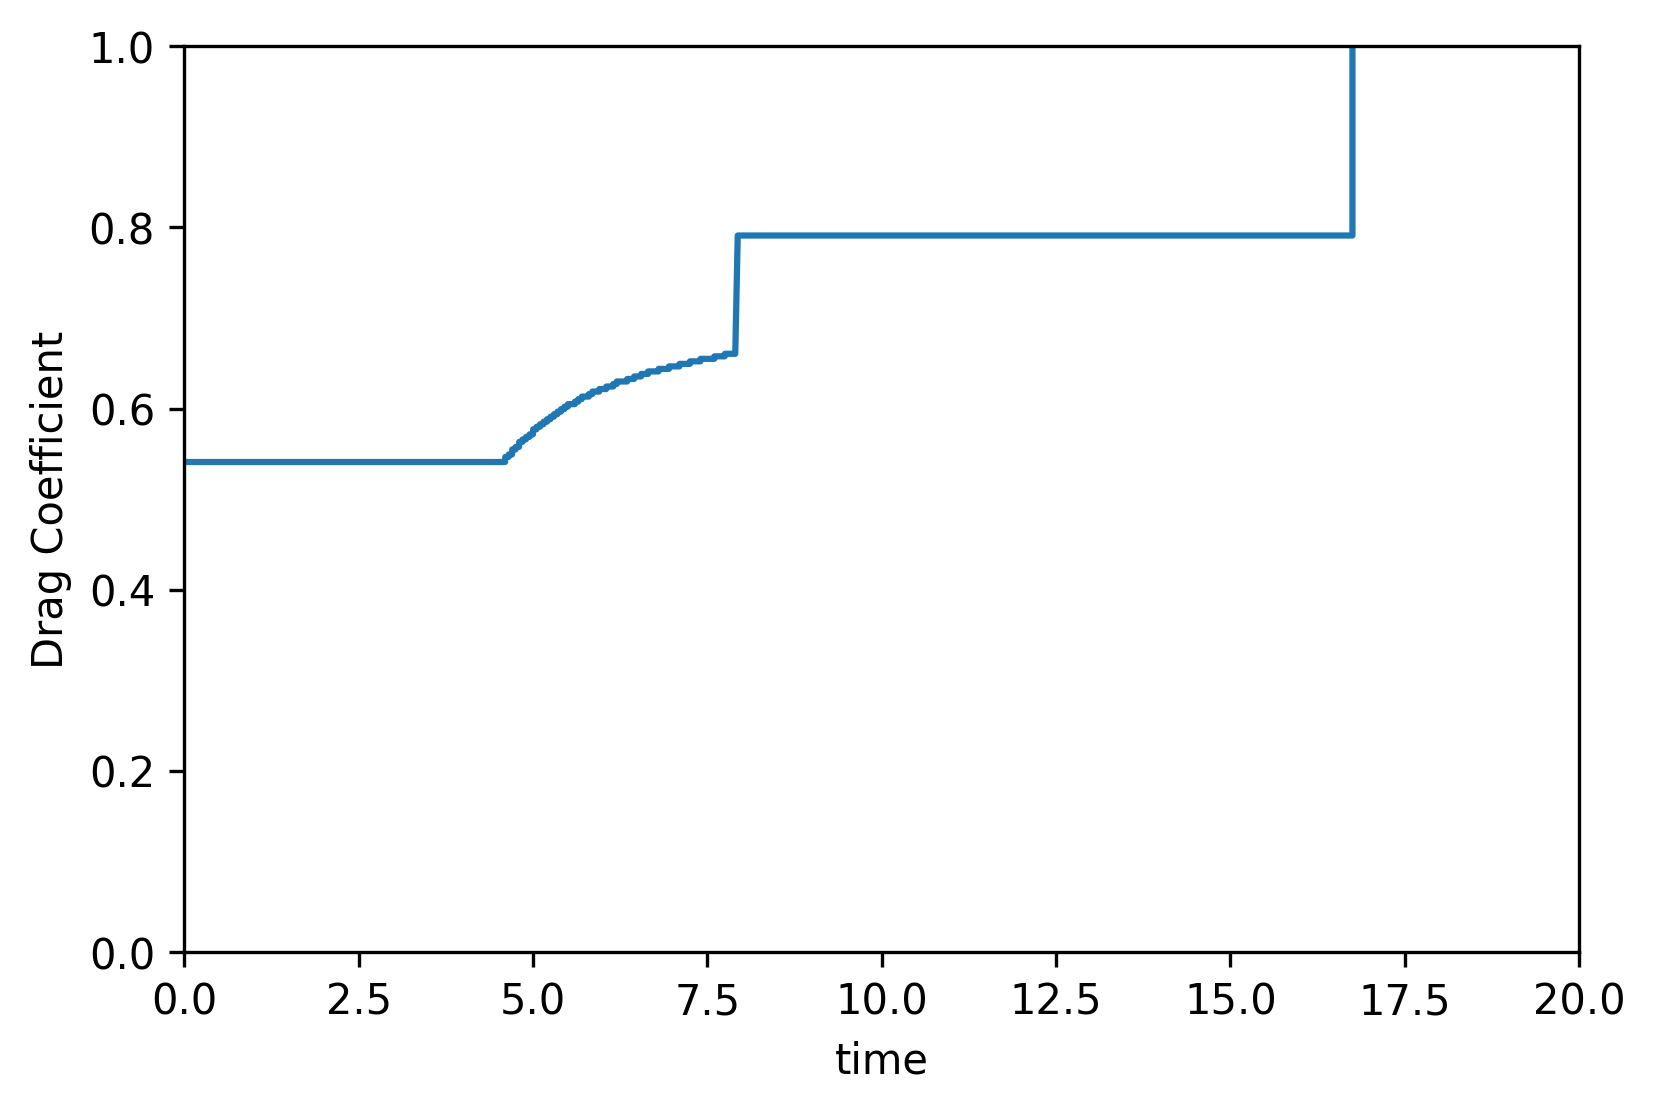

In [266]:
plt.figure(dpi=300)
plt.plot(time,dragCoefficient);
plt.ylim([0,1]);
plt.xlim([0,20]);
plt.xlabel('time')
plt.ylabel('Drag Coefficient');
plt.gcf().set_facecolor('white')

In [267]:
np.max(positions[:,2])

1583.01416469086

In [268]:
np.max(positions[:,2])-targetAlt

22.43816469086005

In [269]:
PercentError = (np.max(positions[:,2])-targetAlt)/targetAlt*100
PercentError

1.437813005637665

In [270]:
np.max(velocities[:,2])

223.8229977364408

In [271]:
positions[np.argmax(velocities[:,2]),2]

204.64129472871915

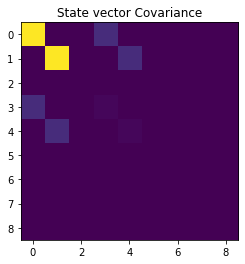

In [272]:
logPkalman = np.sqrt(Pkalman);
logPkalman[np.isneginf(logPkalman)] = 0
plt.imshow(logPkalman);
plt.title('State vector Covariance');